# 00 — Data Build: **Station-Day** (from Hourly Ridership)
**Author:** Joe Todaro

**BLUF:** This notebook converts the MTA **Hourly Ridership** file into a clean **station–day** table, 
adds a U.S. federal holiday flag, and exports a CSV used by EDA and modeling.

**Inputs**
- `../data/raw/turnstile/MTA_Subway_Hourly_Ridership__Beginning_February_2022.csv`
- `../data/raw/federal_holidays.csv`

**Output**
- `../data/interim/station_day.csv`



## 1) Configuration

In [1]:
from pathlib import Path
import os, pandas as pd, numpy as np, matplotlib.pyplot as plt

plt.rcParams['figure.figsize']=(10,5)
plt.rcParams['axes.grid']=True

# --- Adjust these paths if your repo uses a different layout ---
HOURLY_PATH   = '../data/raw/turnstile/MTA_Subway_Hourly_Ridership__Beginning_February_2022.csv'
HOLIDAYS_PATH = '../data/raw/federal_holidays.csv'
OUT_DIR       = '../data/interim'
OUT_CSV       = f'{OUT_DIR}/station_day.csv'

Path(OUT_DIR).mkdir(parents=True, exist_ok=True)

print('Hourly file exists:', os.path.exists(HOURLY_PATH), HOURLY_PATH)
print('Holidays file exists:', os.path.exists(HOLIDAYS_PATH), HOLIDAYS_PATH)

Hourly file exists: True ../data/raw/turnstile/MTA_Subway_Hourly_Ridership__Beginning_February_2022.csv
Holidays file exists: True ../data/raw/federal_holidays.csv


## 2) Load Hourly Ridership

In [ ]:
# We read only columns we need
usecols = ['transit_timestamp','station_complex','ridership']

df_h = pd.read_csv(HOURLY_PATH, usecols=usecols, low_memory=False)

print('Hourly shape:', df_h.shape)
display(df_h.head())

Hourly shape: (1048575, 3)


,transit_timestamp,station_complex,ridership
0,1/8/2024 17:00,8 Av (N),57
1,1/8/2024 17:00,"5 Av/59 St (N,R,W)",72
2,1/8/2024 18:00,"Tremont Av (B,D)",23
3,1/8/2024 18:00,Tompkinsville (SIR),4
4,1/8/2024 18:00,"Bowery (J,Z)",10


## 3) Clean & Aggregate Station–Day

In [ ]:
# Parse datetime to date; normalize station name
df_h['ts'] = pd.to_datetime(df_h['transit_timestamp'], errors='coerce')
df_h['date'] = df_h['ts'].dt.date
df_h['station'] = df_h['station_complex'].astype(str).str.strip()
df_h['ridership'] = pd.to_numeric(df_h['ridership'], errors='coerce')

# Drop bad rows
df_h = df_h.dropna(subset=['date','station'])

# Aggregate hourly to daily per station
station_day = (
    df_h.groupby(['date','station'], as_index=False)['ridership'].sum()
)

print('Station-day:', station_day.shape, '| stations:', station_day['station'].nunique())
display(station_day.head())

Station-day: (15032, 3) | stations: 428


,date,station,ridership
0,2023-09-01,25 St (R),1
1,2023-09-01,"72 St (1,2,3)",1
2,2023-09-01,"86 St (C,B)",2862
3,2023-09-01,Baychester Av (5),1
4,2023-09-01,"Broad St (J,Z)",1


## 4) Holidays Join (US Federal)

In [4]:
# The provided holidays file has columns: 'date', 'official_name', etc.
# We parse 'date' and generate a binary holiday flag.
hol = pd.read_csv(HOLIDAYS_PATH, low_memory=False)

# Choose a date column robustly
hdate_col = None
for c in hol.columns:
    if c.lower() == 'date' or 'date' in c.lower():
        hdate_col = c
        break
if hdate_col is None:
    raise ValueError('No date-like column found in holidays CSV.')

hol['date'] = pd.to_datetime(hol[hdate_col], errors='coerce').dt.date
hol = hol.dropna(subset=['date']).drop_duplicates(subset=['date'])

name_col = None
for k in ('official_name','holiday','holiday_name','name'):
    for c in hol.columns:
        if c.lower()==k:
            name_col = c; break
    if name_col: break

hol['holiday_name'] = hol[name_col].astype(str) if name_col else ''
hol['is_holiday'] = 1  # each row represents a holiday date
hol = hol[['date','holiday_name','is_holiday']]

print('Holidays rows:', len(hol))
display(hol.head())

# Merge
sd = station_day.merge(hol[['date','is_holiday']], on='date', how='left')
sd['is_holiday'] = sd['is_holiday'].fillna(0).astype(int)

# Calendar features
sdt = pd.to_datetime(sd['date'])
sd['dow'] = sdt.dt.weekday            # 0=Mon
sd['is_weekend'] = sd['dow'].isin([5,6]).astype(int)

print('Final station-day:', sd.shape)
display(sd.head())

Holidays rows: 0


C:\Users\JoeJu\AppData\Local\Temp\ipykernel_7496\3214714240.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  hol['date'] = pd.to_datetime(hol[hdate_col], errors='coerce').dt.date


,date,holiday_name,is_holiday


Final station-day: (15032, 6)


,date,station,ridership,is_holiday,dow,is_weekend
0,2023-09-01,25 St (R),1,0,4,0
1,2023-09-01,"72 St (1,2,3)",1,0,4,0
2,2023-09-01,"86 St (C,B)",2862,0,4,0
3,2023-09-01,Baychester Av (5),1,0,4,0
4,2023-09-01,"Broad St (J,Z)",1,0,4,0


## 5) Save Output

In [5]:
sd.to_csv(OUT_CSV, index=False)
print('✅ Saved ->', OUT_CSV)

✅ Saved -> ../data/interim/station_day.csv


## 6) Quick QA Plots

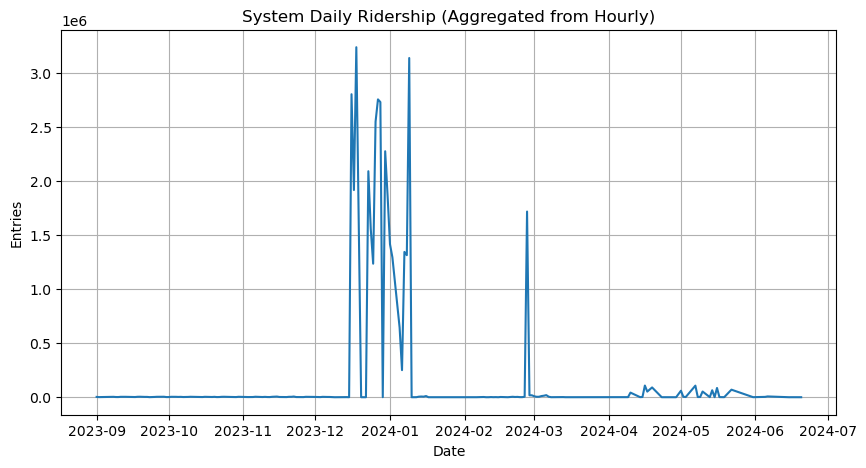

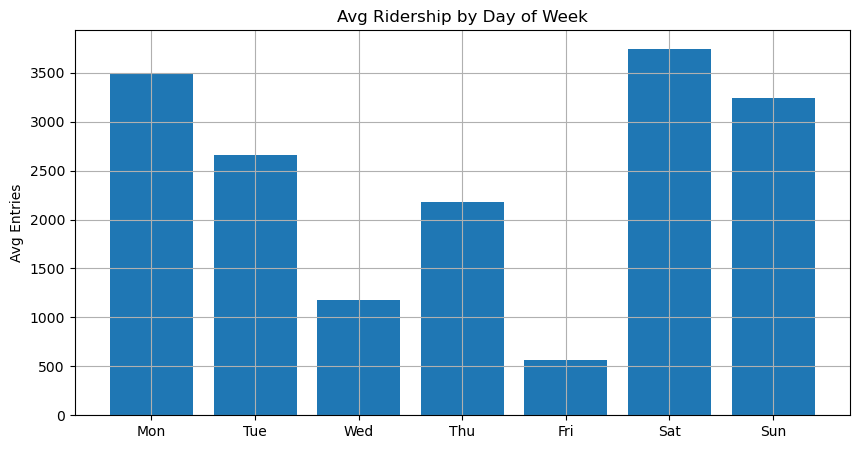

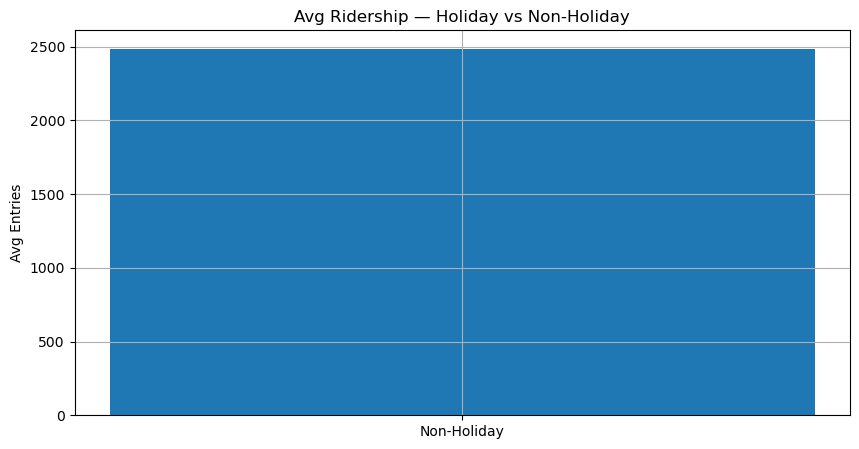

In [6]:
# System-level daily trend
dtrend = sd.groupby('date')['ridership'].sum().sort_index()
fig, ax = plt.subplots()
ax.plot(pd.to_datetime(dtrend.index), dtrend.values)
ax.set_title('System Daily Ridership (Aggregated from Hourly)')
ax.set_ylabel('Entries'); ax.set_xlabel('Date')
plt.show()

# Day-of-week pattern
avg_dow = sd.groupby('dow')['ridership'].mean().reindex([0,1,2,3,4,5,6])
fig, ax = plt.subplots()
ax.bar(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'], avg_dow.values)
ax.set_title('Avg Ridership by Day of Week')
ax.set_ylabel('Avg Entries')
plt.show()

# Holiday vs Non-Holiday
avg_h = sd.groupby('is_holiday')['ridership'].mean().reindex([0,1])
fig, ax = plt.subplots()
ax.bar(['Non-Holiday','Holiday'], avg_h.values)
ax.set_title('Avg Ridership — Holiday vs Non-Holiday')
ax.set_ylabel('Avg Entries')
plt.show()